# Load in data

In [98]:

import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("./Data/depression_dataset_reddit_cleaned.csv", sep=";")
# Kolonner: 'clean_text', 'is_depression'


In [99]:

# only include texts of more than 20 words 
#df = df[df.clean_text.str.split().str.len() > 15]

print(df['is_depression'].value_counts())

# only include 20% of the data 
#df = df.sample(frac=0.2, random_state=42)

# split til træning/test (80/20) – vi genbruger denne split for alle metoder

df_train, df_test = train_test_split(
    df, test_size=0.2, stratify=df.is_depression, random_state=42
)

X_train_texts = df_train.clean_text.tolist()
y_train = df_train.is_depression.values
X_test_texts  = df_test.clean_text.tolist()
y_test = df_test.is_depression.values



is_depression
0    3900
1    3831
Name: count, dtype: int64


In [100]:
# get count of each class in df_train and df_text
print("Train set class distribution:")
print(df_train.is_depression.value_counts())
print("Test set class distribution:")
print(df_test.is_depression.value_counts())

Train set class distribution:
is_depression
0    3120
1    3064
Name: count, dtype: int64
Test set class distribution:
is_depression
0    780
1    767
Name: count, dtype: int64


In [101]:
# create df_train_0 and df_train_1
df_train_0 = df_train[df_train.is_depression == 0]
df_train_1 = df_train[df_train.is_depression == 1]

# create df_test_0 and df_test_1
df_test_0 = df_test[df_test.is_depression == 0]
df_test_1 = df_test[df_test.is_depression == 1]

In [102]:
# get mean and std of each class in df_train
mean_0 = df_train_0.clean_text.str.split().str.len().mean()
std_0 = df_train_0.clean_text.str.split().str.len().std()
mean_1 = df_train_1.clean_text.str.split().str.len().mean()
std_1 = df_train_1.clean_text.str.split().str.len().std()
print("Mean and std of class 0 in train set:")
print(f"Mean: {mean_0}, Std: {std_0}")
print("Mean and std of class 1 in train set:")
print(f"Mean: {mean_1}, Std: {std_1}")
# get mean and std of each class in df_test
mean_0 = df_test_0.clean_text.str.split().str.len().mean()
std_0 = df_test_0.clean_text.str.split().str.len().std()
mean_1 = df_test_1.clean_text.str.split().str.len().mean()
std_1 = df_test_1.clean_text.str.split().str.len().std()
print("Mean and std of class 0 in test set:")
print(f"Mean: {mean_0}, Std: {std_0}")
print("Mean and std of class 1 in test set:")
print(f"Mean: {mean_1}, Std: {std_1}")


Mean and std of class 0 in train set:
Mean: 14.251923076923077, Std: 7.268804613350525
Mean and std of class 1 in train set:
Mean: 136.94060052219322, Std: 191.58488867554195
Mean and std of class 0 in test set:
Mean: 14.287179487179488, Std: 7.207155889389107
Mean and std of class 1 in test set:
Mean: 132.29726205997392, Std: 160.73432267554583


In [103]:
# split into a 0 and 1 df
df_train_0 = df_train[df_train.is_depression == 0]
df_train_1 = df_train[df_train.is_depression == 1]

# find mean text length and sd text length for each df and print them
mean_0 = df_train_0.clean_text.str.split().str.len().mean()
sd_0 = df_train_0.clean_text.str.split().str.len().std()
mean_1 = df_train_1.clean_text.str.split().str.len().mean()
sd_1 = df_train_1.clean_text.str.split().str.len().std()
print(f"Mean text length for 0: {mean_0}, SD: {sd_0}")
print(f"Mean text length for 1: {mean_1}, SD: {sd_1}")
# save train and test dat

Mean text length for 0: 14.251923076923077, SD: 7.268804613350525
Mean text length for 1: 136.94060052219322, SD: 191.58488867554195


# Topic Modelling

## Streamlined vectorizer, embedding model 

In [104]:
from sklearn.feature_extraction.text import CountVectorizer

shared_vect = CountVectorizer(
    max_features = 5000,
    #stop_words   = "english",
    token_pattern= r"(?u)\b\w+\b",
)

# same embedding model for all models
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer("all-MiniLM-L6-v2")

## BERTopic m. MiniLM

In [105]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from umap import UMAP
import numpy as np

from umap import UMAP
from bertopic import BERTopic

# 1) Recreate UMAP exactly as BERTopic would—
#    but add your random_state
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,     # this matches BERTopic’s default embedding dims
    min_dist=0.0,
    metric="cosine",
    low_memory=False,
    random_state=42      # <— your fixed seed
)

# 2) Pass that UMAP into BERTopic
topic_model = BERTopic(
    embedding_model = embedder,
    vectorizer_model = shared_vect,
    umap_model       = umap_model,
    nr_topics        = 20,
    verbose          = False
)


# 3) Fit / transform as before
train_topics, _ = topic_model.fit_transform(X_train_texts)
test_topics,  _ = topic_model.transform(X_test_texts)

# 4) One-hot encode the topic IDs
enc = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_train_bert = enc.fit_transform(np.array(train_topics).reshape(-1,1))
X_test_bert  = enc.transform   (np.array(test_topics ).reshape(-1,1))

print("Train shape:", X_train_bert.shape)   # → (n_train, n_topics)
print("Test  shape:", X_test_bert.shape)    # → (n_test,  n_topics)


Train shape: (6184, 20)
Test  shape: (1547, 20)


In [106]:
# save topics x words as csv
topics_df = topic_model.get_topic_info()
# only keep columns 0 and 3
topics_df = topics_df.loc[:, ['Topic', 'Representation']]

# now build a DataFrame whose rows are topics and whose columns are 0,1,2… word-positions
words_by_topic = pd.DataFrame(
    topics_df['Representation'].tolist(),        # list‐of‐lists → 2D array
    index = topics_df['Topic']                   # label each row by the topic number
)

# transpose so that *columns* are topics and *rows* are the word‐positions (1st word, 2nd word,…)
wide = words_by_topic.T

# optionally, rename the row‐index to something meaningful:
wide.index = [f'word_{i+1}' for i in wide.index]

# save to csv
wide.to_csv("./Topics/topics_bert.csv", sep=";", index=True, header=True)

## LDA

In [107]:
# LDA
from sklearn.decomposition       import LatentDirichletAllocation

cv_lda   = shared_vect

lda  = LatentDirichletAllocation(
    n_components=20,
    random_state=42,
    max_iter    = 10,
    learning_method="batch"
)
W_train_lda = cv_lda.fit_transform(X_train_texts)

X_train_lda = lda.fit_transform(W_train_lda)
X_test_lda  = lda.transform(cv_lda.transform(X_test_texts))


In [109]:
feature_names = cv_lda.get_feature_names_out()
n_top_words = 10    # change to however many words you want per topic

rows = []
for topic_idx, topic_weights in enumerate(lda.components_):
    top_idxs = topic_weights.argsort()[::-1][:n_top_words]
    top_words = [feature_names[i] for i in top_idxs]
    rows.append({
        "Topic": topic_idx,
        "Representation": top_words
    })

df_topics = pd.DataFrame(rows)
words_by_topic = pd.DataFrame(
    df_topics['Representation'].tolist(),
    index = df_topics['Topic']
)

# 3) transpose so columns are topics, rows are word position
wide = words_by_topic.T

# 4) optionally rename the row index to something like word_1, word_2, …
wide.index = [f"word_{i+1}" for i in wide.index]

wide.to_csv("./Topics/topics_lda.csv", sep=";", index=True, header=True)



## S3

In [110]:
from turftopic import SemanticSignalSeparation
#from turftopic.vectorizers.spacy import NounPhraseCountVectorizer

# KeyNMF (“S3”)
model_s3  = SemanticSignalSeparation(
    n_components=20,
    encoder      = embedder,     # see below
    vectorizer   = shared_vect,
    random_state = 42
)
X_train_s3 = model_s3.fit_transform(X_train_texts)
X_test_s3  = model_s3.transform(X_test_texts)

[12:30:03] Documents encoded.                                                                         ]8;id=577568;file:///Users/sofiascharf-matthiesen/miniconda3/envs/mlstack/lib/python3.10/site-packages/turftopic/models/decomp.py\decomp.py]8;;\:]8;id=908453;file:///Users/sofiascharf-matthiesen/miniconda3/envs/mlstack/lib/python3.10/site-packages/turftopic/models/decomp.py#141\141]8;;\

[12:30:04] Decomposition done.                                                                        ]8;id=938303;file:///Users/sofiascharf-matthiesen/miniconda3/envs/mlstack/lib/python3.10/site-packages/turftopic/models/decomp.py\decomp.py]8;;\:]8;id=879810;file:///Users/sofiascharf-matthiesen/miniconda3/envs/mlstack/lib/python3.10/site-packages/turftopic/models/decomp.py#144\144]8;;\

           Term extraction done.                                                                      ]8;id=297765;file:///Users/sofiascharf-matthiesen/miniconda3/envs/mlstack/lib/python3.10/site-packages/turftopic/models/decomp.py\decomp.py]8;;\:]8;id=261053;file:///Users/sofiascharf-matthiesen/miniconda3/envs/mlstack/lib/python3.10/site-packages/turftopic/models/decomp.py#147\147]8;;\

[12:30:07] Vocabulary encoded.                                                                        ]8;id=189503;file:///Users/sofiascharf-matthiesen/miniconda3/envs/mlstack/lib/python3.10/site-packages/turftopic/models/decomp.py\decomp.py]8;;\:]8;id=864519;file:///Users/sofiascharf-matthiesen/miniconda3/envs/mlstack/lib/python3.10/site-packages/turftopic/models/decomp.py#157\157]8;;\

           Model fitting done.                                                                        ]8;id=267114;file:///Users/sofiascharf-matthiesen/miniconda3/envs/mlstack/lib/python3.10/site-packages/turftopic/models/decomp.py\decomp.py]8;;\:]8;id=789395;file:///Users/sofiascharf-matthiesen/miniconda3/envs/mlstack/lib/python3.10/site-packages/turftopic/models/decomp.py#170\170]8;;\

In [111]:
# make output from model_s3.print_topics() into a dataframe
topics_s3 = model_s3.get_topics()
topics_s3_words = {}

# make topics_s3_words into a dataframe
df_s3 = pd.DataFrame(topics_s3)

# create a new column ’words’ that contains only the words
df_s3['words'] = df_s3[1].apply(lambda lst: [word for word, score in lst])

# only include column 0 and 2 
df_s3 = df_s3[[0, 'words']]

top_words = {
    f"topic_{topic_id}": words
    for topic_id, words in zip(df_s3[0], df_s3['words'])
}

df_s3 = pd.DataFrame(top_words)

# save to csv
df_s3.to_csv("./Topics/topics_s3.csv", sep=";", index=True, header=True)

### Assigning feature names

In [112]:
# BERTopic (topics_bert_ommer.csv; columns '-1', '0'…'18')
features_bert = [
    "",
    "Stopwords & Common Tokens",           # -1: the, you, to, is, i…
    "Pronouns & Function Words",           # 0: i, to, and, a, my…
    "Sleep & Rest",                        # 1: sleep, bed, tired, nap…
    "Generic Discourse & Quotations",      # 2: the, you, show, quot, sad…
    "Education & Schoolwork",              # 3: work, homework, class, school…
    "Social Media & Mobile Tech",          # 4: twitter, tweet, iphone, phone…
    "Websites & Uploads",                  # 5: site, upload, website, com…
    "Transportation & Commute",            # 6: bus, traffic, ticket, train…
    "Weather & Nature",                    # 7: rain, cold, snow, sun, weather…
    "French Articles & Fragments",         # 8: de, la, le, pression, d…
    "Pets & Animals",                      # 9: dog, cat, puppy, vet…
    "Affection & Social Support",          # 10: hug, talk, need, someone…
    "Calendars & Events",                  # 11: birthday, monday, tuesday…
    "Fashion & Apparel",                   # 12: wear, color, dress, orange…
    "Internet Slang & Fillers",            # 13: amp, sadly, re, up, got…
    "Football Personalities",              # 14: pogba, mourinho, paul…
    "Current Events (Italy/Earthquake)",   # 15: italy, earthquake, news…
    "Socioeconomic & Mental Health",       # 16: depression, inflation, great…
    "Questions & Gratitude",               # 17: understand, how, thanks, t…
    "Books & Reading",                     # 18: book, library, reading, read…
]

# LDA (topics_lda_ommer.csv; columns '0'…'19')
features_lda = [
    "",
    "Female References",                   # 0: her, she, ...
    "Core Function Words",                 # 1: it, a, the, s, on
    "Pronouns & Entities",                 # 2: amp, i, my, it, the
    "First-Person Narration",              # 3: i, to, the, up, m
    "Self-Focus",                          # 4: i, and, my, a, to
    "Male References",                     # 5: he, him, his, t, i
    "Negation & Depression",               # 6: to, no, depression, and, my
    "Generic Pronouns A",                  # 7: i, to, t, my, and
    "Generic Pronouns B",                  # 8: i, a, and, to, the
    "Contractions & Negation",             # 9: im, dont, cant, me, ...
    "Depression Keywords",                 # 10: depression, the, you, your…
    "Generic Pronouns C",                  # 11: i, to, and, it, t
    "Generic Pronouns D",                  # 12: i, to, and, the, my
    "Quotes & French Terms",               # 13: d, quot, de, le, la
    "Depression & Anxiety",                # 14: depression, anxiety, break…
    "Function Word Cluster",               # 15: a, to, and, of, i
    "Physical Symptoms",                   # 16: cold, feeling, headache, symptom…
    "Function Words E",                    # 17: the, is, my, in, a
    "Generic Pronouns E",                  # 18: i, and, to, a, me
    "Second-Person Address",               # 19: you, to, the, a, is
]

# S3 (topics_s3_fair.csv; columns 'topic_0'…'topic_19')
features_s3 = [
    "",
    "Assault & Violence",                  # topic_0: molested, assault, violated…
    "Mental Health Conditions",            # topic_1: aspergers, mentalhealth, madness…
    "Loneliness & Mood",                   # topic_2: unloved, lonesome, pleasant…
    "Abuse & Therapy",                     # topic_3: abuser, abused, therapy, abuse…
    "Adverbs & Modifiers",                 # topic_4: agonising, mundane, slightly…
    "Curiosity & Frequency",               # topic_5: curious, often, wondering…
    "Family & Parenting",                  # topic_6: parenting, mum, mother…
    "Anxiety & Fear",                      # topic_7: anxiety, panic, terrified…
    "Gender & Appearance",                 # topic_8: woman, gorgeous, female…
    "Media & Downloads",                   # topic_9: itunes, download, youtube…
    "Sleep & Rest",                        # topic_10: sleep, asleep, nap, bedtime…
    "Entertainment & Celebrities",         # topic_11: cast, nicolerichie, episode…
    "Psychiatric Medications",             # topic_12: hydroxyzine, prescribed, dosage…
    "Depression & Mood Disorders",         # topic_13: depression, depressive, antidepressant…
    "Socializing & Introversion",          # topic_14: introverted, socializing, hangout…
    "Satisfaction & Workplace",            # topic_15: noticeable, happy, satisfied…
    "Healthcare & Assistance",             # topic_16: assistance, contact, hospitalized…
    "Social Media Platforms",              # topic_17: twitter, tweetdeck, facebook…
    "Physical Illness & Symptoms",         # topic_18: swollen, vomiting, throat…
    "French Language & Stopwords",         # topic_19: une, und, pas, dans, un
]


In [120]:
# load csvs
df_s3 = pd.read_csv("./Topics/topics_s3.csv", sep=";")
df_lda = pd.read_csv("./Topics/topics_lda.csv", sep=";")
df_bert = pd.read_csv("./Topics/topics_bert.csv", sep=";")

#name each column in the topics csvs the feature name and overwrite
df_s3.columns = features_s3
df_lda.columns = features_lda
df_bert.columns = features_bert

# save to csv
df_s3.to_csv("./Topics/topics_s3.csv", sep=";", index=False, header=True)
df_lda.to_csv("./Topics/topics_lda.csv", sep=";", index=False, header=True)
df_bert.to_csv("./Topics/topics_bert.csv", sep=";", index=False, header=True)


# Test Classifier on diff Top Mod Approaches

In [121]:
feature_sets = {
    #"TF-IDF":    (X_train_tfidf, X_test_tfidf),
    #"LIWC":       (X_train_liwc,  X_test_liwc),
    "LDA":      (X_train_lda,  X_test_lda, features_lda[1:]),
    "BERTopic":   (X_train_bert,  X_test_bert, features_bert[1:]),
    #"RoBERTa-NMF":(X_train_nmf,   X_test_nmf),
    "S3":         (X_train_s3,    X_test_s3, features_s3[1:]),
}

## RF

In [122]:
from sklearn.ensemble       import RandomForestClassifier
from sklearn.metrics        import f1_score, precision_score, recall_score, accuracy_score
from sklearn.inspection     import permutation_importance
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd
import numpy as np

results              = {}
best_models          = {}
feature_importances  = {}

# define your CV splitter once
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, (X_tr, X_te, feat) in feature_sets.items():
    print(f"\n→ {name:6s}  Train={X_tr.shape}  Test={X_te.shape}")

    # 0) quick CV on the training set
    rf = RandomForestClassifier(
        class_weight    = "balanced",
        random_state    = 42,
        n_jobs          = -1
    )
    cv_scores = cross_val_score(rf, X_tr, y_train,
                                cv=cv,
                                scoring='f1',
                                n_jobs=-1)
    print(f"  CV F1: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

    # 1) fit on full training data
    rf.fit(X_tr, y_train)

    # 2) evaluate on hold-out
    y_pred  = rf.predict(X_te)
    oos_f1  = f1_score(y_test, y_pred)
    oos_acc = accuracy_score(y_test, y_pred)
    oos_prec= precision_score(y_test, y_pred, zero_division=0)
    oos_rec = recall_score(y_test, y_pred, zero_division=0)
    print(f"  OOS  F1: {oos_f1:.3f}   Acc: {oos_acc:.3f}   Prec: {oos_prec:.3f}   Rec: {oos_rec:.3f}")

    # 3) permutation importances
    perm = permutation_importance(rf, X_te, y_test, n_repeats=10, random_state=42)
    imp_df = (
        pd.DataFrame({
            "feature":    feat,
            "importance": perm.importances_mean,
            "std_error":  perm.importances_std
        })
        .sort_values("importance", ascending=False)
        .head(5)
        .reset_index(drop=True)
    )
    print("  Top 5 importances:")
    print(imp_df.to_string(index=False, float_format="%.4f"))

    # 4) record everything
    results[name]                = {
        "CV F1":      cv_scores.mean(),
        "CV std":     cv_scores.std(),
        "OOS F1":     oos_f1,
        "Accuracy":   oos_acc,
        "Precision":  oos_prec,
        "Recall":     oos_rec,
    }
    best_models[name]            = rf
    feature_importances[name]    = imp_df

# Summarize
summary = (
    pd.DataFrame.from_dict(results, orient="index")
      .rename_axis("Method")
)
print("\n=== Summary ===")
print(summary.to_string(float_format="%.3f"))



→ LDA     Train=(6184, 20)  Test=(1547, 20)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable 	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment

  CV F1: 0.880 ± 0.008
  OOS  F1: 0.889   Acc: 0.895   Prec: 0.940   Rec: 0.842
  Top 5 importances:
               feature  importance  std_error
First-Person Narration      0.0120     0.0040
  Depression & Anxiety      0.0112     0.0021
   Depression Keywords      0.0081     0.0027
 Quotes & French Terms      0.0043     0.0018
    Generic Pronouns C      0.0037     0.0020

→ BERTopic  Train=(6184, 20)  Test=(1547, 20)
  CV F1: 0.933 ± 0.007
  OOS  F1: 0.908   Acc: 0.913   Prec: 0.963   Rec: 0.858
  Top 5 importances:
                      feature  importance  std_error
    Pronouns & Function Words      0.4063     0.0061
  French Articles & Fragments      0.0088     0.0006
    Stopwords & Common Tokens      0.0052     0.0007
Socioeconomic & Mental Health      0.0015     0.0004
       Football Personalities      0.0013     0.0000

→ S3      Train=(6184, 20)  Test=(1547, 20)
  CV F1: 0.941 ± 0.004
  OOS  F1: 0.946   Acc: 0.947   Prec: 0.954   Rec: 0.939
  Top 5 importances:
           

### Feature Importance Dataframe

In [123]:
import os
import pandas as pd
from sklearn.inspection import permutation_importance

# assume feature_sets, y_test, best_models all exist
os.makedirs("feature_importances", exist_ok=True)

for name, (_, X_te, feat) in feature_sets.items():
    print(f"\n→ {name}")
    print(f"  Test shape: {X_te.shape}")

    # pull in the fitted RF model
    rf = best_models[name]

    # compute permutation importances for the RF
    perm = permutation_importance(
        rf, X_te, y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    df_imp = (
        pd.DataFrame({
            "feature":    feat,
            "importance": perm.importances_mean,
            "std_error":  perm.importances_std
        })
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )

    # save to CSV
    out_path = os.path.join(
        "feature_importances/Dep/",
        f"feature_importances_{name}.csv"
    )
    df_imp.to_csv(out_path, index=False)
    print(f"  → saved feature importances to {out_path}")



→ LDA
  Test shape: (1547, 20)
  → saved feature importances to feature_importances/feature_importances_LDA.csv

→ BERTopic
  Test shape: (1547, 20)
  → saved feature importances to feature_importances/feature_importances_BERTopic.csv

→ S3
  Test shape: (1547, 20)
  → saved feature importances to feature_importances/feature_importances_S3.csv


## Correlation Matrices

In [124]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# where to dump your plots
os.makedirs("correlation_plots", exist_ok=True)

for name, (X_tr, X_te, feat) in feature_sets.items():
    # build DataFrame (here I’m using the train‐split; swap in X_te if you prefer)
    df = pd.DataFrame(X_tr, columns=feat)

    # compute correlation matrix
    corr = df.corr()

    # plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr, vmin=-1, vmax=1, cmap="RdBu_r")
    ax.set_xticks(range(len(feat)))
    ax.set_yticks(range(len(feat)))
    ax.set_xticklabels(feat, rotation=90)
    ax.set_yticklabels(feat)
    ax.set_title(f"Feature Correlation: {name}")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # tidy layout & save
    plt.tight_layout()
    out_path = os.path.join("correlation_plots", f"corr_{name}.png")
    plt.savefig(out_path, dpi=150)
    plt.close(fig)

    print(f"→ saved correlation heatmap for {name} to {out_path}")


→ saved correlation heatmap for LDA to correlation_plots/corr_LDA.png
→ saved correlation heatmap for BERTopic to correlation_plots/corr_BERTopic.png
→ saved correlation heatmap for S3 to correlation_plots/corr_S3.png


## Confusion Matrices

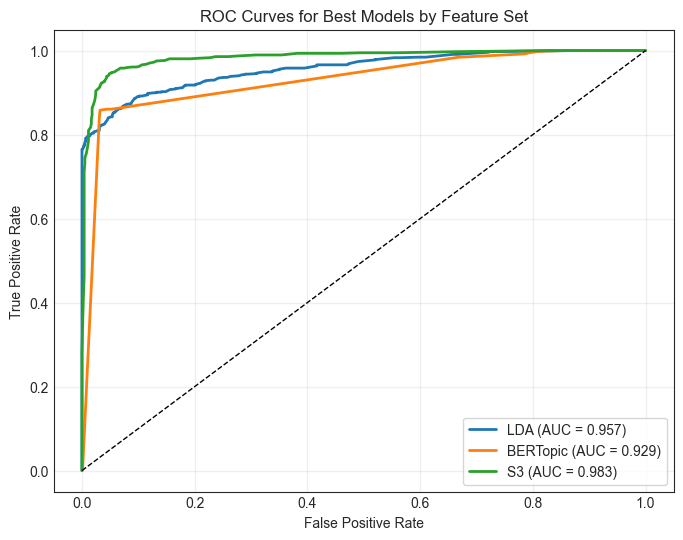

In [125]:
# ── 1) Combined ROC/AUC Curves ────────────────────────────────────────────────

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(8,6))

for name, model in best_models.items():
    X_te = feature_sets[name][1]
    # get positive‐class probabilities
    probs = model.predict_proba(X_te)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc:.3f})")

# Plot 45° line for reference
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Best Models by Feature Set")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


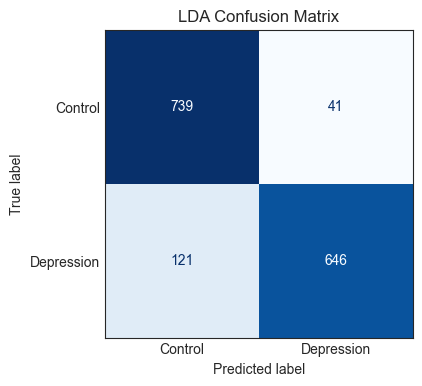

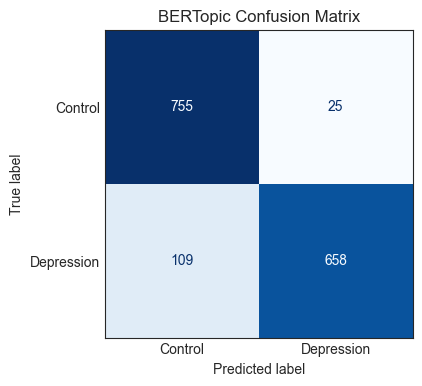

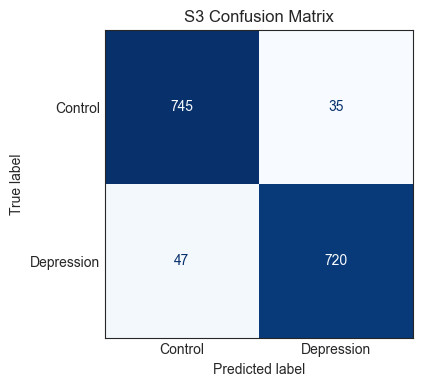

In [126]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

label_names = {0: "Control", 1: "Depression"}
sns.set_style('white')  # or 'ticks'


for name, model in best_models.items():
    X_te   = feature_sets[name][1]
    y_pred = model.predict(X_te)

    # Build CM with true-rows = [1,0], predicted-cols = [1,0]
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

    # Use display_labels in the same order [1,0]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[label_names[0], label_names[1]]  # ["Depression","Control"]
    )
    fig, ax = plt.subplots(figsize=(4,4))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)

    # Now set x-axis to [0,1] → ["Control","Depression"]
    ax.set_xticks([0, 1])
    ax.set_xticklabels([label_names[0], label_names[1]])
    # And y-axis to [1,0] → ["Depression","Control"]
    ax.set_yticks([0, 1])
    ax.set_yticklabels([label_names[0], label_names[1]])

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"{name} Confusion Matrix")
    plt.show()


# Diversity Scores & Similarity Scores

In [141]:
# load csvs
df_lda = pd.read_csv('./Topics/topics_lda.csv', sep=";")
df_bert = pd.read_csv('./Topics/topics_bert.csv', sep=";")
df_s3 = pd.read_csv('./Topics/topics_s3.csv', sep=";") 

In [142]:
import numpy as np
import itertools

# assume df_s3 is your DataFrame of shape (K, n_topics)
# each column is a list of the top-K words for that topic
topic_sets = [set(df_s3[col]) for col in df_s3.columns]
n_topics = len(topic_sets)

# 1) mean pairwise Jaccard similarity
jaccard_scores = []
for A, B in itertools.combinations(topic_sets, 2):
    j = len(A & B) / len(A | B)
    jaccard_scores.append(j)
mean_similarity = np.mean(jaccard_scores)

# 2a) topic‑diversity as 1 - mean_jaccard
diversity_jaccard = 1 - mean_similarity

# 2b) alternative “unique‑ratio” diversity: 
#    total unique words across all topics divided by (n_topics*K)
all_words = set().union(*topic_sets)
K = df_s3.shape[0]
diversity_unique_ratio = len(all_words) / (n_topics * K)

print(f"Mean Jaccard similarity:     {mean_similarity:.4f}")
print(f"Diversity (1 − mean Jaccard): {diversity_jaccard:.4f}")
print(f"Diversity (unique ratio):     {diversity_unique_ratio:.4f}")


Mean Jaccard similarity:     0.0005
Diversity (1 − mean Jaccard): 0.9995
Diversity (unique ratio):     0.9905


In [145]:
import numpy as np
import itertools

# assume df_s3 is your DataFrame of shape (K, n_topics)
# each column is a list of the top-K words for that topic
topic_sets = [set(df_lda[col]) for col in df_lda.columns]
n_topics = len(topic_sets)

# 1) mean pairwise Jaccard similarity
jaccard_scores = []
for A, B in itertools.combinations(topic_sets, 2):
    j = len(A & B) / len(A | B)
    jaccard_scores.append(j)
mean_similarity = np.mean(jaccard_scores)

# 2a) topic‑diversity as 1 - mean_jaccard
diversity_jaccard = 1 - mean_similarity

# 2b) alternative “unique‑ratio” diversity: 
#    total unique words across all topics divided by (n_topics*K)
all_words = set().union(*topic_sets)
K = df_s3.shape[0]
diversity_unique_ratio = len(all_words) / (n_topics * K)

print(f"Mean Jaccard similarity:     {mean_similarity:.4f}")
print(f"Diversity (1 − mean Jaccard): {diversity_jaccard:.4f}")
print(f"Diversity (unique ratio):     {diversity_unique_ratio:.4f}")


Mean Jaccard similarity:     0.1821
Diversity (1 − mean Jaccard): 0.8179
Diversity (unique ratio):     0.4095


In [143]:
import numpy as np
import itertools

# assume df_s3 is your DataFrame of shape (K, n_topics)
# each column is a list of the top-K words for that topic
topic_sets = [set(df_bert[col]) for col in df_bert.columns]
n_topics = len(topic_sets)

# 1) mean pairwise Jaccard similarity
jaccard_scores = []
for A, B in itertools.combinations(topic_sets, 2):
    j = len(A & B) / len(A | B)
    jaccard_scores.append(j)
mean_similarity = np.mean(jaccard_scores)

# 2a) topic‑diversity as 1 - mean_jaccard
diversity_jaccard = 1 - mean_similarity

# 2b) alternative “unique‑ratio” diversity: 
#    total unique words across all topics divided by (n_topics*K)
all_words = set().union(*topic_sets)
K = df_s3.shape[0]
diversity_unique_ratio = len(all_words) / (n_topics * K)

print(f"Mean Jaccard similarity:     {mean_similarity:.4f}")
print(f"Diversity (1 − mean Jaccard): {diversity_jaccard:.4f}")
print(f"Diversity (unique ratio):     {diversity_unique_ratio:.4f}")


Mean Jaccard similarity:     0.0569
Diversity (1 − mean Jaccard): 0.9431
Diversity (unique ratio):     0.7095


# Embedding Coherence

In [146]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity

# Attempt to import sentence-transformers
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    raise ImportError("The sentence-transformers package is required. Install with: pip install sentence-transformers")

def compute_embedding_coherence(df_wide, model_name="all-MiniLM-L6-v2"):
    """
    Given a wide-format DataFrame where each column is a list of top-K words for a topic,
    computes both internal and external coherence per topic using word embeddings.

    Returns a DataFrame with columns:
      - topic
      - internal_coherence (mean pairwise cosine similarity within topic words)
      - external_coherence (mean cosine similarity between topic words and all other words)
    """
    # 1) Load the embedding model
    model = SentenceTransformer(model_name)

    # 2) Build a list of all unique words across topics, ignoring non-strings
    unique_words = set()
    for topic in df_wide.columns:
        for w in df_wide[topic]:
            if isinstance(w, str):
                unique_words.add(w)
    all_words = sorted(unique_words)

    # 3) Compute embeddings for each unique word
    embeddings = model.encode(all_words, convert_to_numpy=True)
    emb_map = dict(zip(all_words, embeddings))

    # 4) Compute coherence metrics for each topic
    records = []
    for topic in df_wide.columns:
        # Filter out any non-strings in this topic's word list
        words = [w for w in df_wide[topic] if isinstance(w, str)]
        if not words:
            # Skip topics with no valid words
            records.append({
                "topic": topic,
                "internal_coherence": np.nan,
                "external_coherence": np.nan
            })
            continue

        word_embs = np.stack([emb_map[w] for w in words])

        # Internal coherence: average pairwise cosine similarity among topic words
        pair_sims = [
            cosine_similarity(word_embs[i:i+1], word_embs[j:j+1])[0, 0]
            for i, j in combinations(range(len(words)), 2)
        ]
        internal = np.mean(pair_sims) if pair_sims else np.nan

        # External coherence: similarity between topic words and all other words
        other_embs = np.stack(
            [emb for w, emb in emb_map.items() if w not in words]
        )
        ext_sims = cosine_similarity(word_embs, other_embs).flatten()
        external = np.mean(ext_sims) if ext_sims.size else np.nan

        records.append({
            "topic": topic,
            "internal_coherence": internal,
            "external_coherence": external
        })

    return pd.DataFrame(records)

# Example usage:
# df_wide = pd.DataFrame({ 'topic_0': [...], 'topic_1': [...], ... })
# coherence_df = compute_embedding_coherence(df_wide)
# print(coherence_df)


In [147]:
coh_b = compute_embedding_coherence(df_bert)
coh_l = compute_embedding_coherence(df_lda)
coh_s = compute_embedding_coherence(df_s3)

In [148]:
print("LDA:")
print(f"  Internal Coherence: {coh_l['internal_coherence'].mean():.3f} ± {coh_l['internal_coherence'].std():.3f}")
print(f"  External Coherence: {coh_l['external_coherence'].mean():.3f} ± {coh_l['external_coherence'].std():.3f}")
# print mean and std of internal and external coherence for each model
print("BERTopic:")
print(f"  Internal Coherence: {coh_b['internal_coherence'].mean():.3f} ± {coh_b['internal_coherence'].std():.3f}")  
print(f"  External Coherence: {coh_b['external_coherence'].mean():.3f} ± {coh_b['external_coherence'].std():.3f}")

print("S3:")
print(f"  Internal Coherence: {coh_s['internal_coherence'].mean():.3f} ± {coh_s['internal_coherence'].std():.3f}")
print(f"  External Coherence: {coh_s['external_coherence'].mean():.3f} ± {coh_s['external_coherence'].std():.3f}")
# save coherence scores to cs

LDA:
  Internal Coherence: 0.411 ± 0.093
  External Coherence: 0.320 ± 0.025
BERTopic:
  Internal Coherence: 0.381 ± 0.107
  External Coherence: 0.273 ± 0.019
S3:
  Internal Coherence: 0.430 ± 0.105
  External Coherence: 0.222 ± 0.021


# Stop-Words, Non-real words

In [149]:
df_dict = {
    'LDA': df_lda,
    'BERTopic': df_bert,
    'S3': df_s3
}

          Stopword Count  Non-Real Word Count
LDA                  145                   28
BERTopic              81                   21
S3                     5                   36


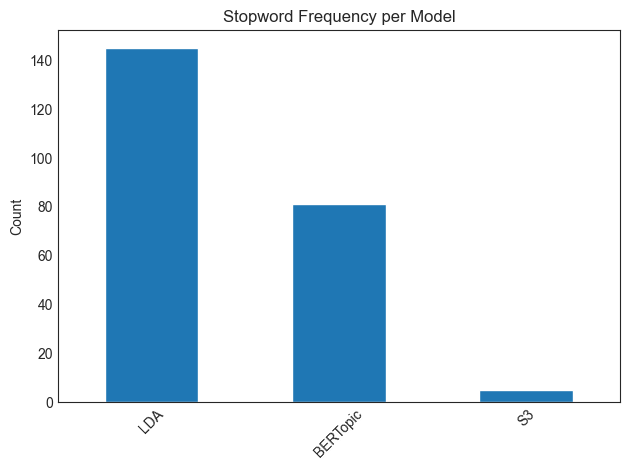

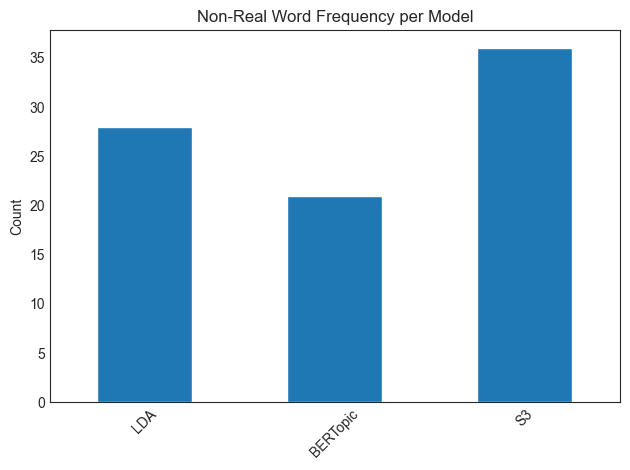

In [150]:
import matplotlib.pyplot as plt
import pandas as pd
from wordfreq import zipf_frequency
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# example: df_dict = {'LDA': lda_df, 'NMF': nmf_df, ...}
stopwords = set(ENGLISH_STOP_WORDS)
valid_single_letters = {'a', 'i'}

def is_real_word(w: str, threshold: float = 3.0) -> bool:
    w = w.lower()
    # skip multi-word phrases entirely
    if " " in w:
        return True
    # allow only 'a' or 'i' for single‐letter tokens
    if len(w) == 1:
        return w in valid_single_letters
    # otherwise check wordfreq frequency
    return zipf_frequency(w, 'en') >= threshold

stop_counts = {}
nonreal_counts = {}

for name, df in df_dict.items():
    words = df.values.flatten().astype(str)
    stop_counts[name]    = sum(w.lower() in stopwords for w in words)
    nonreal_counts[name] = sum(
        (not is_real_word(w)) 
        for w in words
    )

# build summary table
summary_df = pd.DataFrame({
    'Stopword Count':      stop_counts,
    'Non-Real Word Count': nonreal_counts
})

# display
print(summary_df)

# plot stopwords
ax = summary_df['Stopword Count'] \
     .plot.bar(rot=45, title='Stopword Frequency per Model')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# plot non-real words
ax = summary_df['Non-Real Word Count'] \
     .plot.bar(rot=45, title='Non-Real Word Frequency per Model')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()


/var/folders/3x/d81s3p9d121_p6l9czkfl60r0000gp/T/ipykernel_70262/1123401929.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


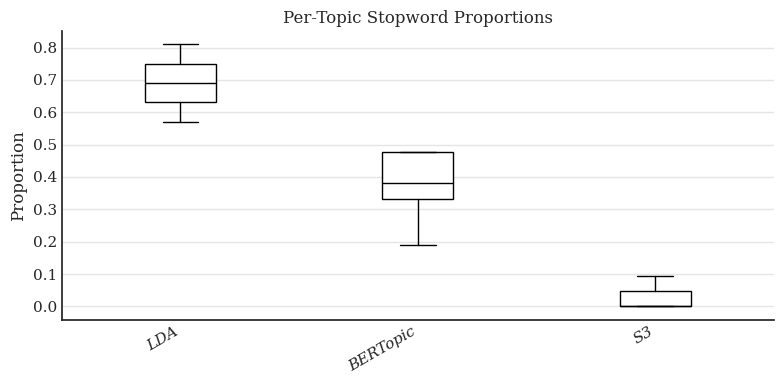

/var/folders/3x/d81s3p9d121_p6l9czkfl60r0000gp/T/ipykernel_70262/1123401929.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


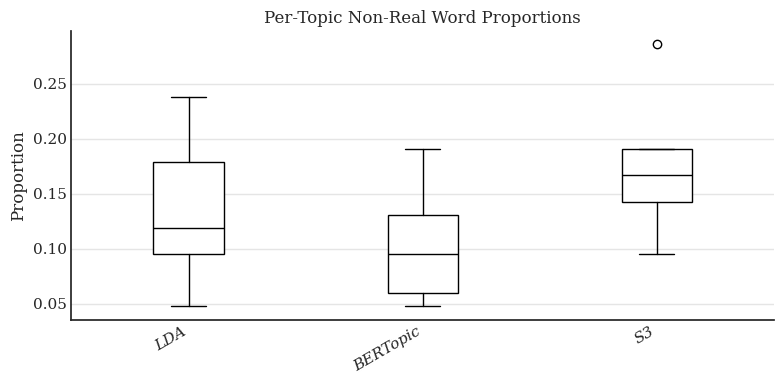

In [153]:
import matplotlib.pyplot as plt
import pandas as pd
from wordfreq import zipf_frequency
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# assume df_dict = {'LDA': lda_df, 'NMF': nmf_df, ...},
# where each df is (n_topics × n_words)
sns.set_theme(style="white")
stopwords = set(ENGLISH_STOP_WORDS)
valid_single_letters = {'a', 'i'}
THRESHOLD = 3.0   # wordfreq threshold

def is_real_word(w: str) -> bool:
    """Return True for multi-word phrases or frequent tokens."""
    w = w.lower()
    if " " in w:
        return True
    if len(w) == 1:
        return w in valid_single_letters
    return zipf_frequency(w, 'en') >= THRESHOLD

# collect per-topic proportions
stop_props    = {}
nonreal_props = {}

for name, df in df_dict.items():
    # df.values is shape (n_topics, n_words)
    stops    = []
    nonreals = []
    for row in df.values:
        words = [str(w) for w in row]
        # proportion of stopwords in this topic
        stops.append(sum(w.lower() in stopwords for w in words) / len(words))
        # proportion of non-real words in this topic
        nonreals.append(sum(not is_real_word(w) for w in words) / len(words))
    stop_props[name]    = stops
    nonreal_props[name] = nonreals

# turn into DataFrames for boxplot convenience
stop_df    = pd.DataFrame(stop_props)
nonreal_df = pd.DataFrame(nonreal_props)

# common styling
plt.rcParams.update({
    'font.family':         'serif',
    'axes.spines.top':     False,
    'axes.spines.right':   False,
    'axes.grid':           True,
    'axes.grid.axis':      'y',
    'grid.color':          '#e5e5e5',
    'grid.linewidth':      1.0,
    'grid.linestyle':      '-',
    'xtick.major.size':    0,
    'ytick.major.size':    0,
})

def styled_boxplot(df, title):
    fig, ax = plt.subplots(figsize=(8, 4))
    # white boxes with black edges
    bp = ax.boxplot(
        [df[col] for col in df.columns],
        labels=df.columns,
        patch_artist=True,
        boxprops=dict(facecolor='white', edgecolor='black'),
        medianprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        flierprops=dict(markeredgecolor='black', markerfacecolor='white')
    )
    # italic & angled x labels
    ax.set_xticklabels(df.columns, rotation=30, ha='right', fontstyle='italic')
    ax.set_ylabel('Proportion')
    ax.set_title(title)
    ax.set_axisbelow(True)
    plt.tight_layout()
    plt.show()

# Plot them!
styled_boxplot(stop_df,    'Per-Topic Stopword Proportions')
styled_boxplot(nonreal_df, 'Per-Topic Non-Real Word Proportions')


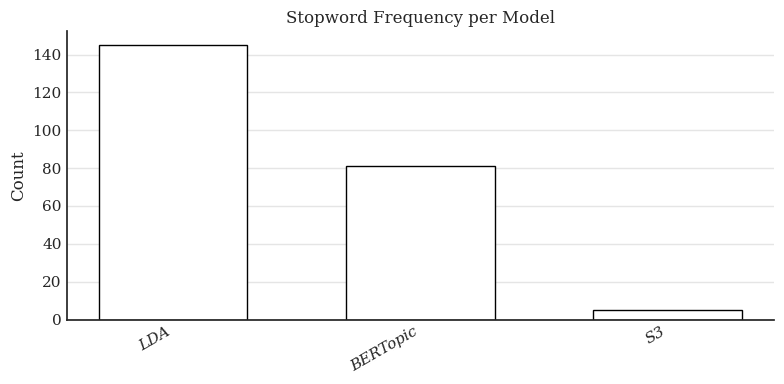

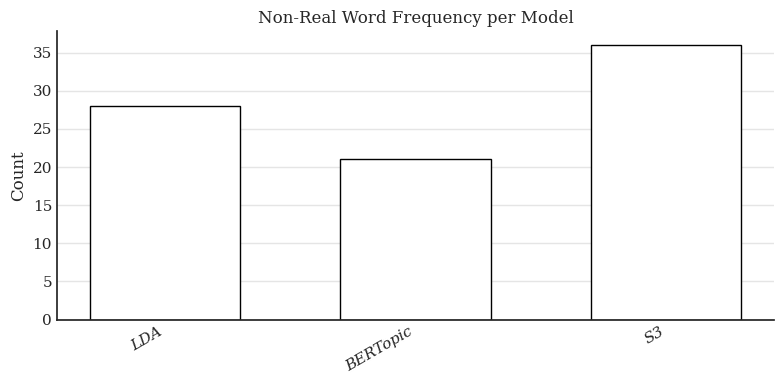

In [154]:
import matplotlib.pyplot as plt
import pandas as pd

# reuse your summary_df from before…

# 1) set up a clean, grid style
plt.rcParams.update({
    'font.family':         'serif',        # serif font
    'axes.spines.top':     False,
    'axes.spines.right':   False,
    'axes.grid':           True,
    'axes.grid.axis':      'y',            # only horizontal gridlines
    'grid.color':          '#e5e5e5',
    'grid.linewidth':      1.0,
    'grid.linestyle':      '-',
    'xtick.major.size':    0,              # hide tick marks
    'ytick.major.size':    0,
})

def make_styled_bar(column, title):
    fig, ax = plt.subplots(figsize=(8, 4))
    # white bars with black edges
    bars = ax.bar(summary_df.index,
                  summary_df[column],
                  edgecolor='black',
                  facecolor='white',
                  width=0.6)
    # italic & angled x‐labels 
    ax.set_xticks(range(len(summary_df)))
    ax.set_xticklabels(summary_df.index,
                       rotation=30,
                       ha='right',
                       fontstyle='italic')
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.set_axisbelow(True)
    plt.tight_layout()
    plt.show()

# now draw your two plots
make_styled_bar('Stopword Count',      'Stopword Frequency per Model')
make_styled_bar('Non-Real Word Count', 'Non-Real Word Frequency per Model')


# Testing on Anxiety

In [156]:
df_anxiety = pd.read_csv("./Data/Combined Data.csv")
df_anxiety = df_anxiety.rename(columns={'statement': 'clean_text'})
# filter for anxiety 
df_anxiety = df_anxiety[df_anxiety['status'].isin(['Anxiety'])]
# make anxiety into 1
df_anxiety['status'] = df_anxiety['status'].replace({'Anxiety': 1})

# exclude nas 
df_anxiety = df_anxiety.dropna(subset=['clean_text', 'status'])

# make all text lower case, remove punctuation 
df_anxiety['clean_text'] = df_anxiety['clean_text'].str.lower()
df_anxiety['clean_text'] = df_anxiety['clean_text'].str.replace(r'[^\w\s]', '', regex=True)

# now we're using all of them as test 
X_test_a = df_anxiety.clean_text.tolist()
y_test_a = df_anxiety.status.tolist()

In [157]:
# get mean and sd text length from df
mean_text_length = df_anxiety['clean_text'].str.split().str.len().mean()
std_text_length = df_anxiety['clean_text'].str.split().str.len().std()
# print them
print(f"Mean text length: {mean_text_length:.2f}")
print(f"Standard deviation text length: {std_text_length:.2f}")

Mean text length: 143.39
Standard deviation text length: 152.20


## Making topic embeddings

In [158]:
# 1) Turn them into the same bag-of-words space:
W_anxiety = cv_lda.transform(X_test_a)
# 2) Map counts → topic proportions:
X_a_lda = lda.transform(W_anxiety)    # shape (n_anxiety, n_topics)

# bert 
X_test_a_bert = enc.transform(np.array(topic_model.transform(X_test_a)[0]).reshape(-1,1))

#s3 
X_test_a_s3 = model_s3.transform(X_test_a)

## Predicting

In [160]:
# use same models as before 
model_lda_a = best_models['LDA']
model_bert_a = best_models['BERTopic']
model_s3_a = best_models['S3']

# predict 
y_pred_a_lda = model_lda_a.predict(X_a_lda)
y_pred_a_bert = model_bert_a.predict(X_test_a_bert)
y_pred_a_s3 = model_s3_a.predict(X_test_a_s3)
# print classification reports 
from sklearn.metrics import classification_report
print(classification_report(y_test_a, y_pred_a_lda))
print(classification_report(y_test_a, y_pred_a_bert))
print(classification_report(y_test_a, y_pred_a_s3))

# make feature importances using permutation importance
perm_a_lda = permutation_importance(model_lda_a, X_a_lda, y_test_a)
perm_a_bert = permutation_importance(model_bert_a, X_test_a_bert, y_test_a)
perm_a_s3 = permutation_importance(model_s3_a, X_test_a_s3, y_test_a)

# save feature importances to df 
df_a_lda = pd.DataFrame(perm_a_lda.importances_mean, columns=['importance'])
df_a_lda['feature'] = features_lda[1:]
df_a_lda['model'] = 'LDA'
df_a_bert = pd.DataFrame(perm_a_bert.importances_mean, columns=['importance'])
df_a_bert['feature'] = features_bert[1:]
df_a_bert['model'] = 'BERTopic'
df_a_s3 = pd.DataFrame(perm_a_s3.importances_mean, columns=['importance'])
df_a_s3['feature'] = features_s3[1:]
df_a_s3['model'] = 'S3'

# save each feature importance df as csv
df_a_lda.to_csv('./feature_importances/Anx/lda_anxiety.csv', index=False)
df_a_bert.to_csv('./feature_importances/Anx/bert_anxiety.csv', index=False)
df_a_s3.to_csv('./feature_importances/Anx/s3_anxiety.csv', index=False)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.80      0.89      3841

    accuracy                           0.80      3841
   macro avg       0.50      0.40      0.44      3841
weighted avg       1.00      0.80      0.89      3841

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.86      0.92      3841

    accuracy                           0.86      3841
   macro avg       0.50      0.43      0.46      3841
weighted avg       1.00      0.86      0.92      3841

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.87      0.93      3841

    accuracy                           0.87      3841
   macro avg       0.50      0.44      0.47      3841
weighted avg       1.00      0.87      0.93      3841



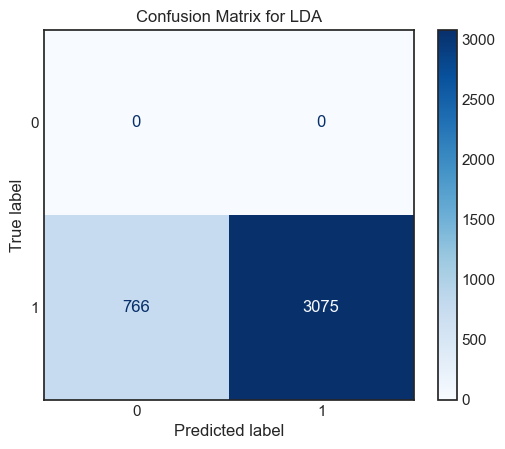

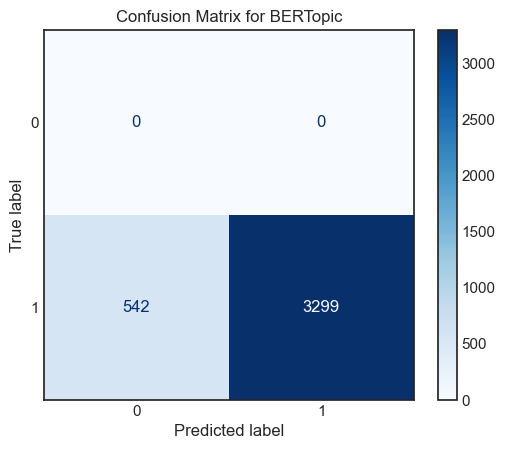

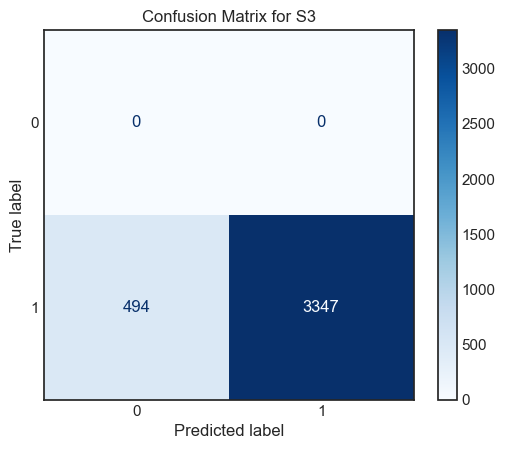

In [161]:
# make confusion matrices, packages are already imported
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
sns.set_style('white')  # or 'ticks'

# make confusion matrices for each model
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# plot confusion matrices for each model
plot_confusion_matrix(y_test_a, y_pred_a_lda, 'LDA')
plot_confusion_matrix(y_test_a, y_pred_a_bert, 'BERTopic')
plot_confusion_matrix(y_test_a, y_pred_a_s3, 'S3')

In [162]:
# convert y_test_a into numpy array
y_test_a = np.array(y_test_a)

In [163]:
# get the indices of the true positives and false negatives from the s3 model
true_positives = np.where((y_test_a == 1) & (y_pred_a_s3 == 1))
false_negatives = np.where((y_test_a == 1) & (y_pred_a_s3 == 0))

true_positives_dep = np.where((y_test == 1) & (y_pred == 1))

In [165]:
# find mean for each topic in X_test_a_s3: 

mean_s3 = np.mean(X_test_a_s3, axis=0)

# compute mean for each topic with indices true_positives
mean_true_positives = np.mean(X_test_a_s3[true_positives], axis=0)
# compute mean for each topic with indices false_negatives
mean_false_negatives = np.mean(X_test_a_s3[false_negatives], axis=0)

mean_actual_depression = np.mean(X_test_s3[true_positives_dep], axis=0)

# mean_s3 is shape (20,)
# features_s3 is length-20 list of names

df_s3 = pd.DataFrame({
    'feature': features_s3[1:],
    'mean_actual_depression': mean_actual_depression,
    'mean_anxiety_all': mean_s3,
    'mean_depression_classified': mean_true_positives,
    'mean_nondepression_classified': mean_false_negatives,
})

# add a column that contains 


# sort df_s3 by mean 
df_s3 = df_s3.sort_values('mean_anxiety_all', ascending=False)
df_s3.to_csv('mean_s3_anxiety.csv', index=False)


## Tables for general Anxiety vs. Depression

In [167]:
import numpy as np
import pandas as pd

# select depression‐labeled test rows
depres_test = np.where(y_test == 1)[0]

# slice out each feature matrix for depression
X_depres_lda  = X_test_lda[depres_test]
X_depres_bert = X_test_bert[depres_test]
X_depres_s3   = X_test_s3[depres_test]

# 1) means
mean_lda_dep  = np.mean(X_depres_lda, axis=0)
mean_bert_dep = np.mean(X_depres_bert, axis=0)
mean_s3_dep   = np.mean(X_depres_s3, axis=0)

mean_lda_a    = np.mean(X_a_lda, axis=0)
mean_bert_a   = np.mean(X_test_a_bert, axis=0)
mean_s3_a     = np.mean(X_test_a_s3, axis=0)

# 2) standard deviations
sd_lda_dep    = np.std(X_depres_lda, axis=0)
sd_bert_dep   = np.std(X_depres_bert, axis=0)
sd_s3_dep     = np.std(X_depres_s3, axis=0)

sd_lda_a      = np.std(X_a_lda, axis=0)
sd_bert_a     = np.std(X_test_a_bert, axis=0)
sd_s3_a       = np.std(X_test_a_s3, axis=0)

# 3) build DataFrames
df_lda = pd.DataFrame({
    'feature':         features_lda[1:],
    'mean_depression': mean_lda_dep,
    'sd_depression':   sd_lda_dep,
    'mean_anxiety':    mean_lda_a,
    'sd_anxiety':      sd_lda_a,
})

df_bert = pd.DataFrame({
    'feature':         features_bert[1:],
    'mean_depression': mean_bert_dep,
    'sd_depression':   sd_bert_dep,
    'mean_anxiety':    mean_bert_a,
    'sd_anxiety':      sd_bert_a,
})

df_s3 = pd.DataFrame({
    'feature':         features_s3[1:],
    'mean_depression': mean_s3_dep,
    'sd_depression':   sd_s3_dep,
    'mean_anxiety':    mean_s3_a,
    'sd_anxiety':      sd_s3_a,
})


In [168]:
for name, df in [('LDA', df_lda),
                 ('BERT', df_bert),
                 ('S3', df_s3)]:

    # 1) compute the difference
    df = df.copy()
    df['diff'] = df['mean_depression'] - df['mean_anxiety']


    # 2) top 5 where depression > anxiety
    top_dep = df.nlargest(5, 'diff')[[
        'feature',
        'mean_depression', 'sd_depression',
        'mean_anxiety',    'sd_anxiety',
        'diff'
    ]]

    # 3) top 5 where anxiety > depression
    top_anx = df.nsmallest(5, 'diff')[[
        'feature',
        'mean_depression', 'sd_depression',
        'mean_anxiety',    'sd_anxiety',
        'diff'
    ]]

    # 4) print
    print(f"\n=== {name} topics ===")
    print("Top 5 more activated in depression:")
    print(top_dep.to_string(index=False))
    print("\nTop 5 more activated in anxiety:")
    print(top_anx.to_string(index=False))



=== LDA topics ===
Top 5 more activated in depression:
              feature  mean_depression  sd_depression  mean_anxiety  sd_anxiety     diff
   Generic Pronouns A         0.157086       0.210523      0.029363    0.089642 0.127723
   Generic Pronouns C         0.177944       0.234847      0.087813    0.174920 0.090131
  Depression Keywords         0.038049       0.104775      0.009701    0.036274 0.028348
 Depression & Anxiety         0.028082       0.124302      0.005375    0.023904 0.022707
Second-Person Address         0.050902       0.123853      0.036588    0.097299 0.014314

Top 5 more activated in anxiety:
                feature  mean_depression  sd_depression  mean_anxiety  sd_anxiety      diff
             Self-Focus         0.216002       0.245261      0.460415    0.297403 -0.244413
Contractions & Negation         0.026345       0.093067      0.086752    0.095903 -0.060407
     Generic Pronouns B         0.064502       0.135790      0.097213    0.150462 -0.032711
      Ph

## Tables for Anxiety inter-prediction differences

In [169]:
import numpy as np
import pandas as pd

# get indices for each model
#lda
lda_indices_ad = np.where((y_test_a == 1) & (y_pred_a_lda == 1))
lda_indices_an = np.where((y_test_a == 1) & (y_pred_a_lda == 0))
#bert
bert_indices_ad = np.where((y_test_a == 1) & (y_pred_a_bert == 1))
bert_indices_an = np.where((y_test_a == 1) & (y_pred_a_bert == 0))
#s3
s3_indices_ad = np.where((y_test_a == 1) & (y_pred_a_s3 == 1))
s3_indices_an = np.where((y_test_a == 1) & (y_pred_a_s3 == 0))

# create new X matrices
lda_anx_dep = X_a_lda[lda_indices_ad]
lda_anx_nor = X_a_lda[lda_indices_an]

bert_anx_dep = X_test_a_bert[bert_indices_ad]
bert_anx_nor = X_test_a_bert[bert_indices_an]

s3_anx_dep = X_test_a_s3[s3_indices_ad]
s3_anx_nor = X_test_a_s3[s3_indices_an]

# compute means for each x 
mean_lda_anx_dep = np.mean(lda_anx_dep, axis=0)
mean_lda_anx_nor = np.mean(lda_anx_nor, axis=0)
mean_bert_anx_dep = np.mean(bert_anx_dep, axis=0)
mean_bert_anx_nor = np.mean(bert_anx_nor, axis=0)
mean_s3_anx_dep = np.mean(s3_anx_dep, axis=0)
mean_s3_anx_nor = np.mean(s3_anx_nor, axis=0)

# compute standard deviations for each x
sd_lda_anx_dep = np.std(lda_anx_dep, axis=0)
sd_lda_anx_nor = np.std(lda_anx_nor, axis=0)
sd_bert_anx_dep = np.std(bert_anx_dep, axis=0)
sd_bert_anx_nor = np.std(bert_anx_nor, axis=0)
sd_s3_anx_dep = np.std(s3_anx_dep, axis=0)
sd_s3_anx_nor = np.std(s3_anx_nor, axis=0)

# build dataframe for each model 
df_lda = pd.DataFrame({
    'feature': features_lda[1:],
    'mean_anxiety_depression': mean_lda_anx_dep,
    'sd_anxiety_depression': sd_lda_anx_dep,
    'mean_anxiety_nondepression': mean_lda_anx_nor,
    'sd_anxiety_nondepression': sd_lda_anx_nor,
})

df_bert = pd.DataFrame({
    'feature': features_bert[1:],
    'mean_anxiety_depression': mean_bert_anx_dep,
    'sd_anxiety_depression': sd_bert_anx_dep,
    'mean_anxiety_nondepression': mean_bert_anx_nor,
    'sd_anxiety_nondepression': sd_bert_anx_nor,
})

df_s3 = pd.DataFrame({
    'feature': features_s3[1:],
    'mean_anxiety_depression': mean_s3_anx_dep,
    'sd_anxiety_depression': sd_s3_anx_dep,
    'mean_anxiety_nondepression': mean_s3_anx_nor,
    'sd_anxiety_nondepression': sd_s3_anx_nor,
})

In [170]:
for name, df in [('LDA', df_lda),
                 ('BERT', df_bert),
                 ('S3', df_s3)]:

    # 1) compute the difference
    df = df.copy()
    df['diff'] = df['mean_anxiety_depression'] - df['mean_anxiety_nondepression']


    # 2) top 5 where depression > anxiety
    top_dep = df.nlargest(5, 'diff')[[
        'feature',
        'mean_anxiety_depression', 'sd_anxiety_depression',
        'mean_anxiety_nondepression',    'sd_anxiety_nondepression',
        'diff'
    ]]

    # 3) top 5 where anxiety > depression
    top_anx = df.nsmallest(5, 'diff')[[
        'feature',
        'mean_anxiety_depression', 'sd_anxiety_depression',
        'mean_anxiety_nondepression',    'sd_anxiety_nondepression',
        'diff'
    ]]

    # 4) print
    print(f"\n=== {name} topics ===")
    print("Top 5 more activated in depression classification of anxiety:")
    print(top_dep.to_string(index=False))
    print("\nTop 5 more activated in non-depression classification of anxiety:")
    print(top_anx.to_string(index=False))



=== LDA topics ===
Top 5 more activated in depression classification of anxiety:
           feature  mean_anxiety_depression  sd_anxiety_depression  mean_anxiety_nondepression  sd_anxiety_nondepression      diff
        Self-Focus                 0.537612               0.250871                    0.150520                  0.266282  0.387091
Generic Pronouns B                 0.103041               0.140575                    0.073817                  0.183046  0.029224
Generic Pronouns E                 0.059965               0.106061                    0.047431                  0.141503  0.012534
Generic Pronouns D                 0.033619               0.070336                    0.029799                  0.103473  0.003821
   Male References                 0.004522               0.014409                    0.009108                  0.021631 -0.004585

Top 5 more activated in non-depression classification of anxiety:
                feature  mean_anxiety_depression  sd_anxiety_depr